In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer

RSEED=826

In [70]:
# import data and immediate train test split
df = pd.read_csv('data/data.csv')
df_train, df_test = train_test_split(df, random_state=RSEED)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22917 entries, 3121 to 29745
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      22917 non-null  object 
 1   Date                                                 22917 non-null  object 
 2   Place_ID                                             22917 non-null  object 
 3   target                                               22917 non-null  float64
 4   target_min                                           22917 non-null  float64
 5   target_max                                           22917 non-null  float64
 6   target_variance                                      22917 non-null  float64
 7   target_count                                         22917 non-null  int64  
 8   precipitable_water_entire_atmosphere                 22917 non-null 

In [4]:
df_train.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
3121,2JZW8ZM X 2020-03-09,2020-03-09,2JZW8ZM,27.0,1.0,115.0,1611.93,253,13.070044,86.133336,...,40.859311,-7.812209,57.584962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14141,EVXOAKQ X 2020-03-25,2020-03-25,EVXOAKQ,21.0,5.0,157.0,4908.25,56,26.500000,75.900002,...,57.229369,-121.763823,33.091599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18250,J3HFUPO X 2020-03-24,2020-03-24,J3HFUPO,114.0,63.0,161.0,4848.00,333,20.200001,97.099998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1466,1LC5FAK X 2020-01-03,2020-01-03,1LC5FAK,25.0,5.0,55.0,1144.47,47,14.400000,84.150002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13997,EVB4HVG X 2020-02-04,2020-02-04,EVB4HVG,55.0,9.0,682.0,34813.40,445,26.342857,63.071432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# drop columns with sensor angles as they are not useful for prediction
# as well as 'amf' columns as they hold same information as columns with almost identical name just in different format
for col in df_train.columns:
    if 'angle' in col or 'amf' in col[-3:]:
        df_train.drop([col], axis=1, inplace=True)
        df_test.drop([col], axis=1, inplace=True)

# drop CH4 columns as they include too many nan values
# drop NO2_tropopause_pressure because its highly irregular and probably a weak predictor
drop_cols = ['L3_CH4_CH4_column_volume_mixing_ratio_dry_air', 'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth', "L3_NO2_tropopause_pressure"]
df_train.drop(drop_cols, axis=1, inplace=True)
df_test.drop(drop_cols, axis=1, inplace=True)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22917 entries, 3121 to 29745
Data columns (total 44 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Place_ID X Date                                  22917 non-null  object 
 1   Date                                             22917 non-null  object 
 2   Place_ID                                         22917 non-null  object 
 3   target                                           22917 non-null  float64
 4   target_min                                       22917 non-null  float64
 5   target_max                                       22917 non-null  float64
 6   target_variance                                  22917 non-null  float64
 7   target_count                                     22917 non-null  int64  
 8   precipitable_water_entire_atmosphere             22917 non-null  float64
 9   relative_humidity_2m_above_gro

In [72]:
# drop rows where target value is above 500 as this is already a very extreme value for pm2.5 concentration
df_train = df_train[df_train['target'] < 500]
df_test = df_test[df_test['target'] < 500]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22912 entries, 3121 to 29745
Data columns (total 44 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Place_ID X Date                                  22912 non-null  object 
 1   Date                                             22912 non-null  object 
 2   Place_ID                                         22912 non-null  object 
 3   target                                           22912 non-null  float64
 4   target_min                                       22912 non-null  float64
 5   target_max                                       22912 non-null  float64
 6   target_variance                                  22912 non-null  float64
 7   target_count                                     22912 non-null  int64  
 8   precipitable_water_entire_atmosphere             22912 non-null  float64
 9   relative_humidity_2m_above_gro

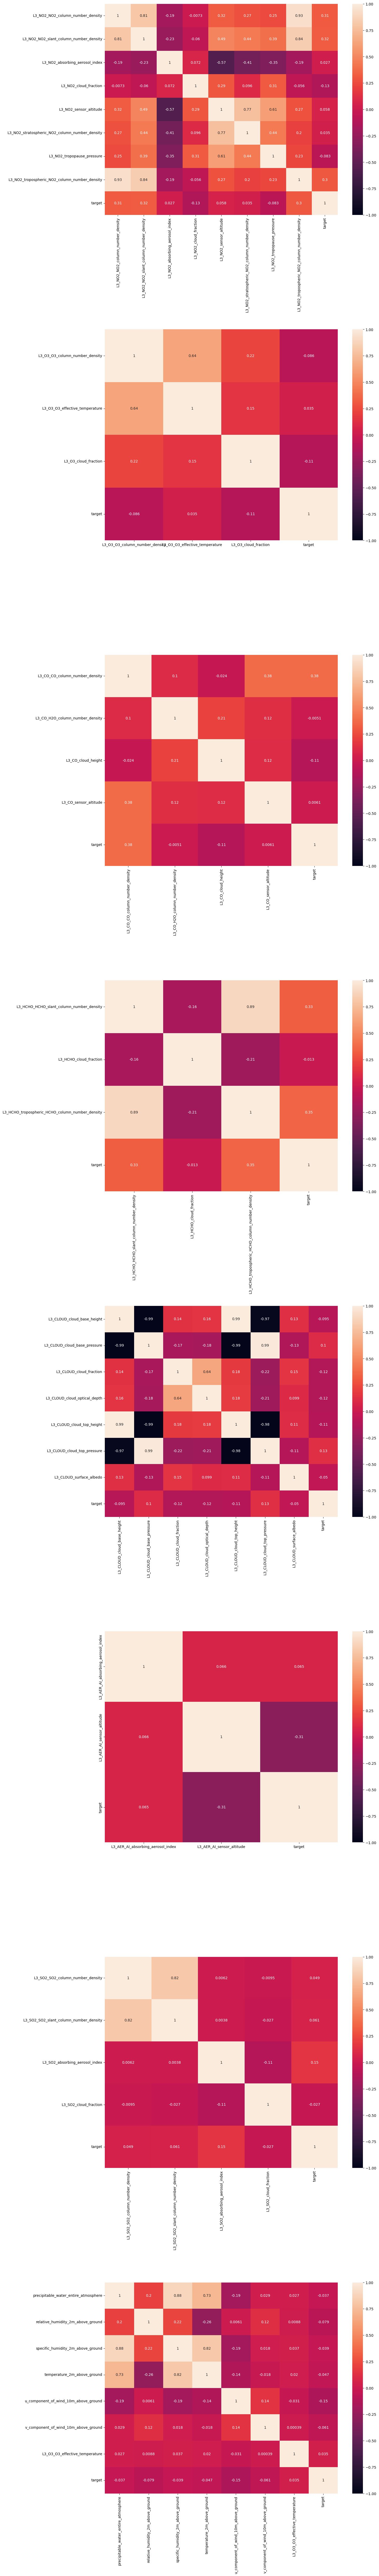

In [7]:
# visualize correlations between columns for each gas separately
gases = ['NO2', 'O3', 'CO', 'HCHO', 'CLOUD', 'AER', 'SO2']

fig, axes = plt.subplots(len(gases)+1, 1, figsize=(16, 100))
axes = axes.flatten()

for ax, gas in zip(axes, gases):
    col_keeps = [col for col in df_train.columns if gas in col]
    corr_gas = df_train[col_keeps + ['target']]
    sns.heatmap(corr_gas.corr(), annot=True, ax=ax, vmin=-1, vmax=1)

# ... and cluster the cols below as weather
weather = ['humidity', 'wind', 'water', 'temperature']

col_keeps = [col for col in df_train.columns for w in weather if w in col]
corr_weather = df_train[col_keeps + ['target']]
sns.heatmap(corr_weather.corr(), annot=True, ax=axes[-1], vmin=-1, vmax=1)

plt.tight_layout(pad = 3)

In [73]:
# drop one of two columns which correlate strongly (>0.7) to prevent multicollinearity
use = ['target'] + list(df_train.columns[8:])
corr_df = df_train[use].corr().abs()

upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

threshold = 0.7
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
print(f'Columns to drop [{len(to_drop)}]: {to_drop}\n')

df_train.drop(to_drop, axis=1, inplace=True)
df_test.drop(to_drop, axis=1, inplace=True)
df_train.info()

Columns to drop [17]: ['specific_humidity_2m_above_ground', 'temperature_2m_above_ground', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_stratospheric_NO2_column_number_density', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_cloud_fraction', 'L3_CO_H2O_column_number_density', 'L3_CO_sensor_altitude', 'L3_HCHO_cloud_fraction', 'L3_HCHO_tropospheric_HCHO_column_number_density', 'L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_AER_AI_absorbing_aerosol_index', 'L3_SO2_SO2_slant_column_number_density', 'L3_SO2_cloud_fraction']

<class 'pandas.core.frame.DataFrame'>
Index: 22912 entries, 3121 to 29745
Data columns (total 27 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Place_ID X Date                           22912 non-null  object 
 1   Date                                      22912 non-null  

In [9]:
# check for duplicates
df_train.duplicated().value_counts()

False    22912
Name: count, dtype: int64

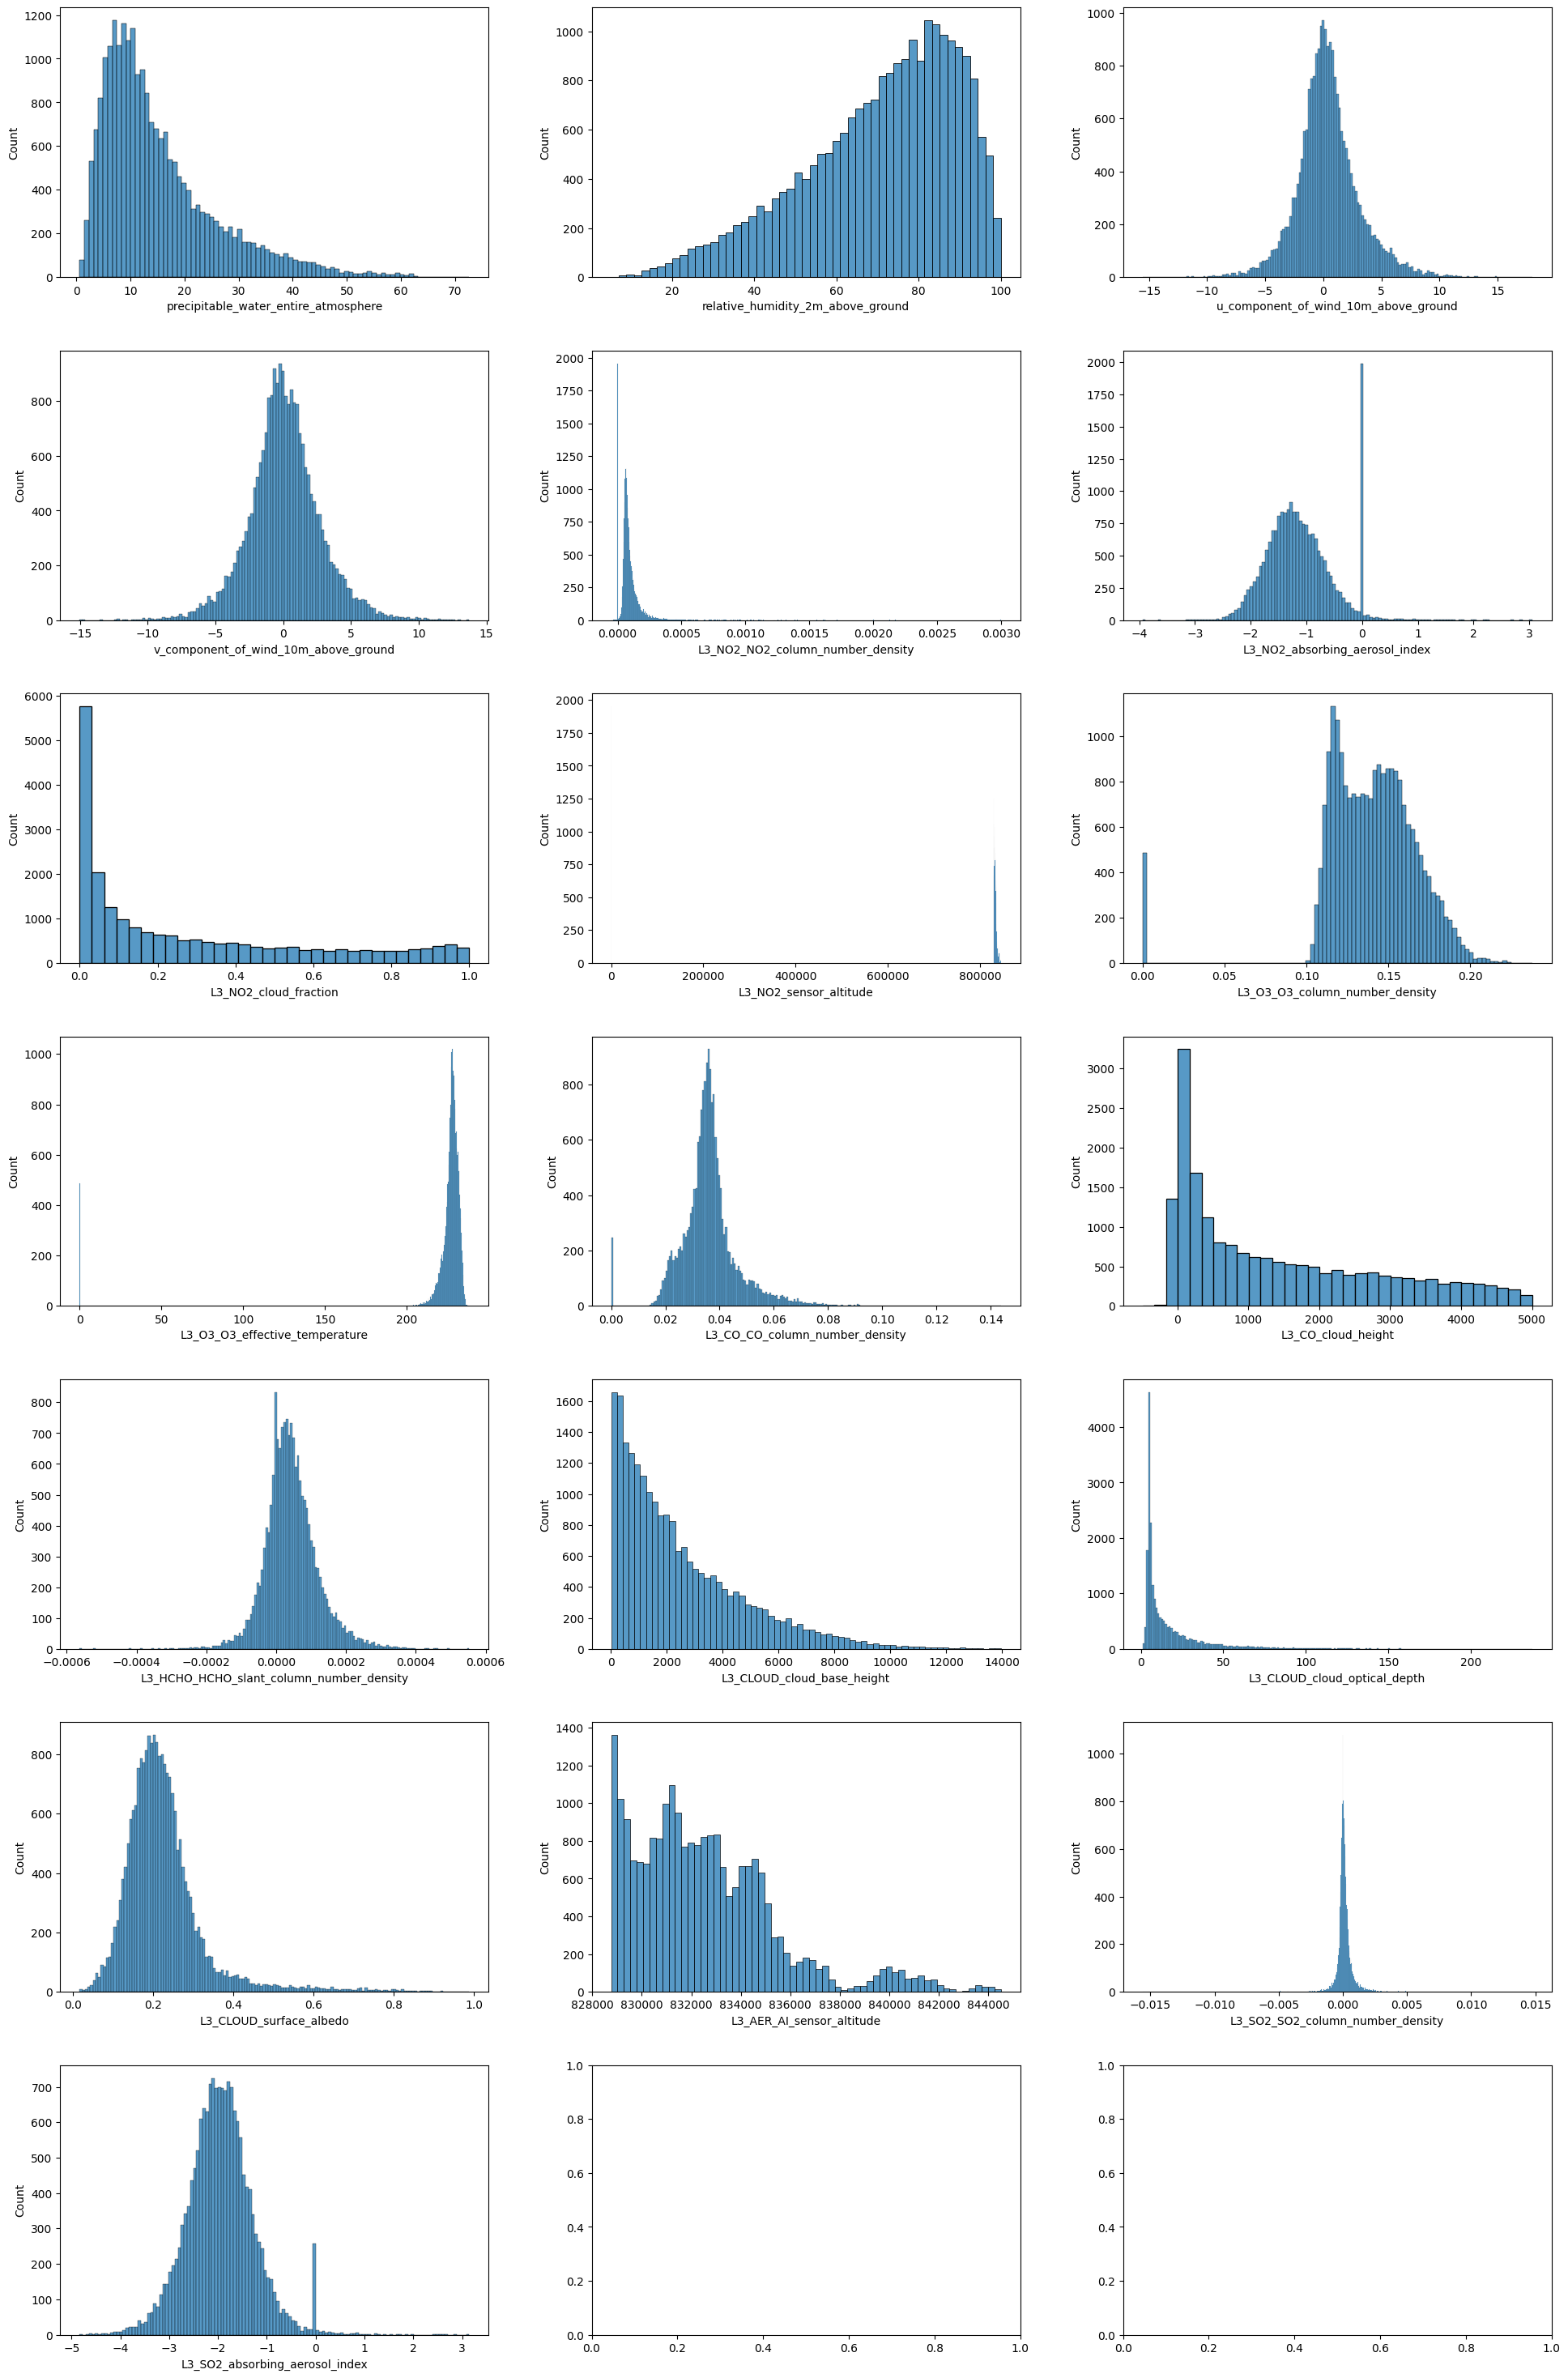

In [74]:
# visualize histograms of features to spot outliers or irregular distributions
fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for ax, col in zip(axes, df_train.columns[8:]):
    sns.histplot(df_train, x=col, ax=ax)

plt.tight_layout(pad=3)

In [11]:
# print descriptive metrics of features to spot outliers
for col in ['target'] + list(df_train.columns[8:]):
    print(f'''{col}
min, mean, max:           {df_train[col].min().round(3)}   {df_train[col].mean().round(3)}   {df_train[col].max().round(3)}
quantiles (25, 50, 75):   {df_train[col].quantile(0.25).round(3)}   {df_train[col].quantile(0.50).round(3)}   {df_train[col].quantile(0.75).round(3)}\n''')

target
min, mean, max:           1.0   61.231   470.0
quantiles (25, 50, 75):   25.0   50.0   80.0

precipitable_water_entire_atmosphere
min, mean, max:           0.664   15.299   72.6
quantiles (25, 50, 75):   7.611   12.2   19.9

relative_humidity_2m_above_ground
min, mean, max:           5.129   70.621   100.0
quantiles (25, 50, 75):   58.815   74.213   85.426

u_component_of_wind_10m_above_ground
min, mean, max:           -15.56   0.409   17.955
quantiles (25, 50, 75):   -1.107   0.219   1.745

v_component_of_wind_10m_above_ground
min, mean, max:           -15.024   0.091   13.728
quantiles (25, 50, 75):   -1.417   0.007   1.571

L3_NO2_NO2_column_number_density
min, mean, max:           -0.0   0.0   0.003
quantiles (25, 50, 75):   0.0   0.0   0.0

L3_NO2_absorbing_aerosol_index
min, mean, max:           -3.942   -1.095   3.051
quantiles (25, 50, 75):   -1.514   -1.171   -0.745

L3_NO2_cloud_fraction
min, mean, max:           0.0   0.278   1.0
quantiles (25, 50, 75):   0.026   0.14

# Baseline Model

<Axes: xlabel='L3_CO_CO_column_number_density', ylabel='target'>

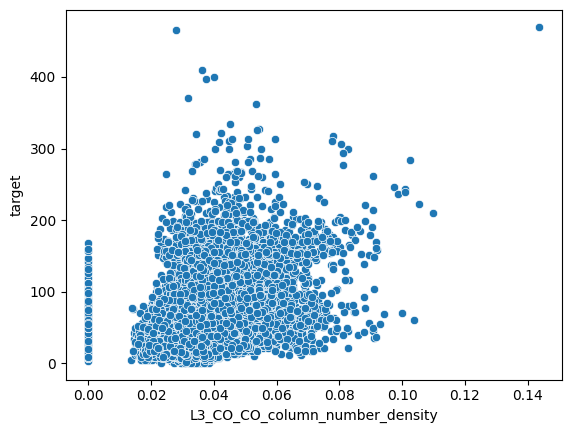

In [12]:
# scatterplot of feature with strongest correlation to target
sns.scatterplot(df_train, x='L3_CO_CO_column_number_density', y='target')

In [20]:
def print_eval_metrics(y_test,y_pred, model_name):
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Results")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")

In [75]:
# baseline model based on features associated with air pollution
def baseline_model(df, target_col, feature_cols=None, random_state=RSEED):
    if feature_cols == None:
        feature_cols = df.select_dtypes(include='number').columns.drop(target_col)

    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state) #, test_size=0.2

    # fill nan with median of train data
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # evaluation
    print_eval_metrics(y_test,y_pred,"Linear Regression")

    return model, y_pred

print('-> based on features associated with air pollution')
cols = ["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground", "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground"] # add clouds?
model, preds = baseline_model(df, target_col="target", feature_cols=cols)

print('\n-> based on feature with strongest correlation to target')
cols = ['L3_CO_CO_column_number_density']
model, preds = baseline_model(df, target_col='target', feature_cols=cols)

-> based on features associated with air pollution
Linear Regression Results
RMSE: 44.768
R²:   0.035

-> based on feature with strongest correlation to target
Linear Regression Results
RMSE: 42.855
R²:   0.116


In [ ]:
# create list with all features that have weird bar at 0
peak_cols = [
    'L3_NO2_NO2_column_number_density',
    'L3_NO2_absorbing_aerosol_index',
    'L3_NO2_sensor_altitude',
    'L3_O3_O3_column_number_density',
    'L3_O3_O3_effective_temperature',
    'L3_CO_CO_column_number_density'
    ]

# replace 0s with nan
df_train[peak_cols] = df_train[peak_cols].replace(0, np.nan)
df_test[peak_cols] = df_test[peak_cols].replace(0, np.nan)


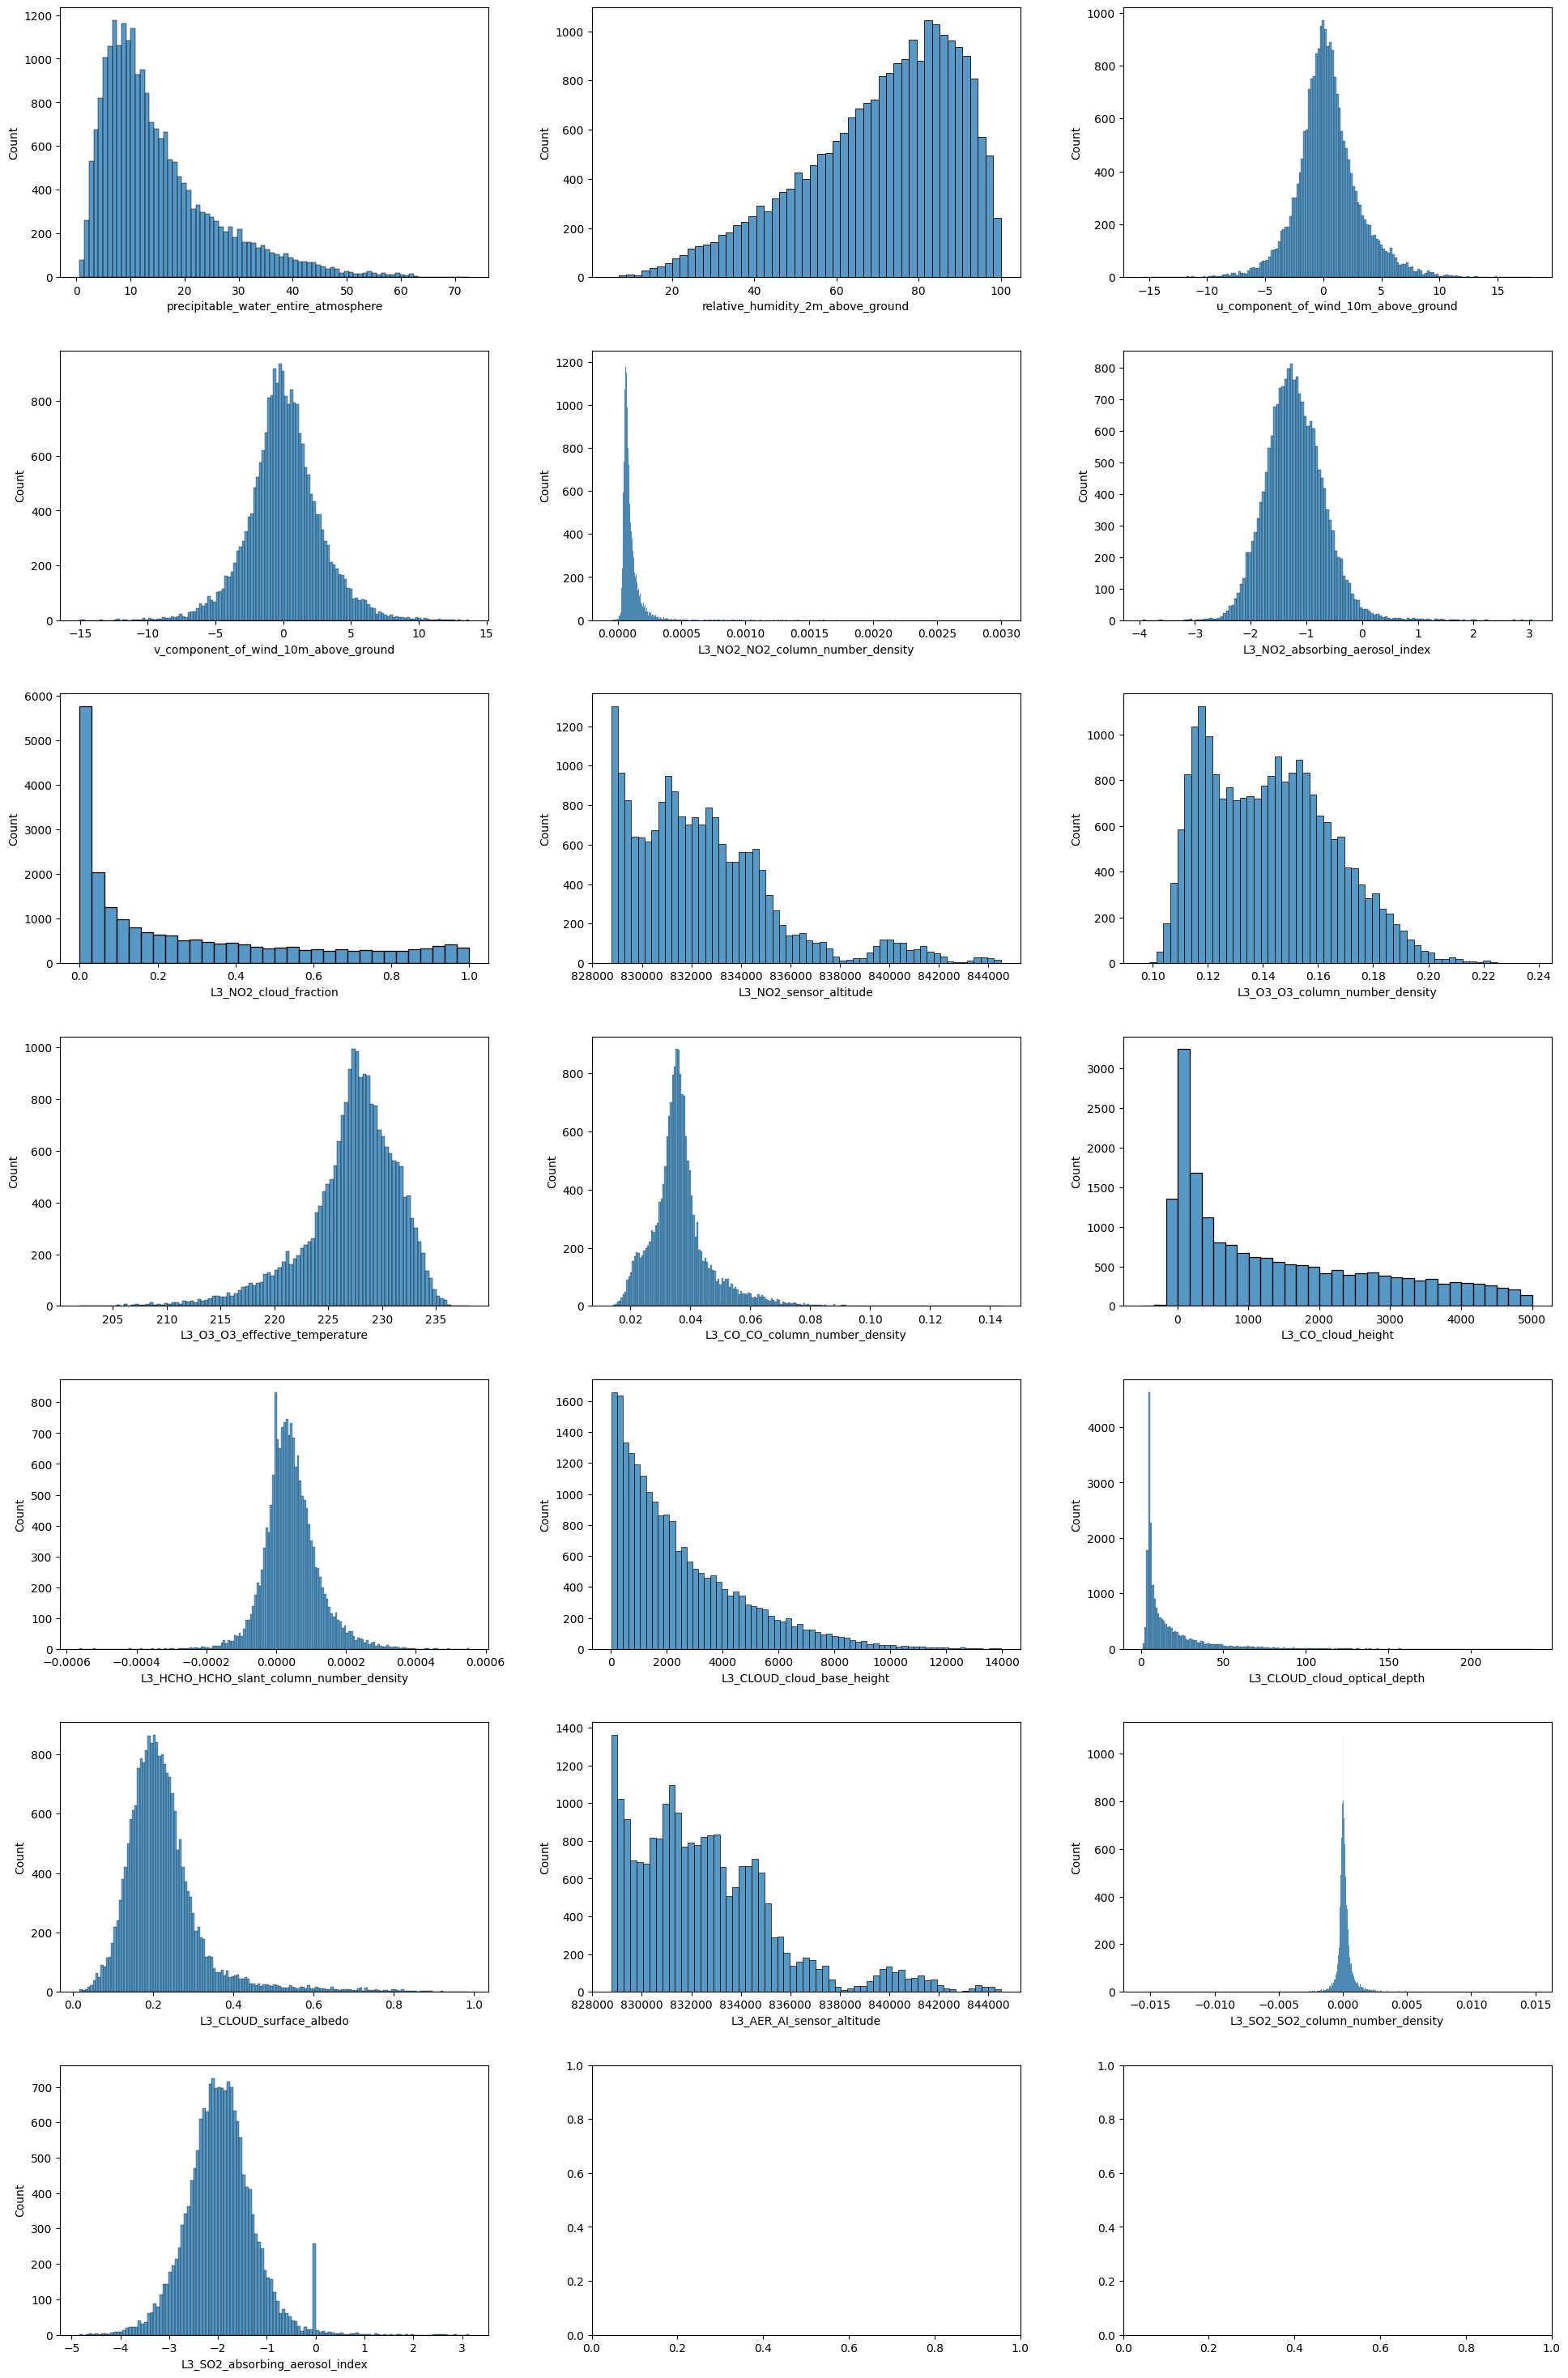

In [78]:
# visualize again to check skew after remove 0
fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for ax, col in zip(axes, df_train.columns[8:]):
    sns.histplot(df_train, x=col, ax=ax)

plt.tight_layout(pad=3)

# Pipeline

In [79]:
# define train and test data and exclude columns of location and date as well as descriptive metrics of target
cols_places = ['Place_ID X Date', 'Date', 'Place_ID']
cols_target = ['target', 'target_min', 'target_max', 'target_variance', 'target_count']

X_train = df_train.drop(cols_places + cols_target, axis=1)
X_test = df_test.drop(cols_places + cols_target, axis=1)
y_train = df_train['target']
y_test = df_test['target']

In [97]:
# select numerical cols
num_cols = X_train.select_dtypes('number').columns.tolist()

# identify skewed cols
skew_thresh = 0.5
skew_cols2 = X_train[num_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skew_cols = skew_cols2[abs(skew_cols2) > skew_thresh].index.tolist()
print(f"{len(skew_cols)} skewed cols: {skew_cols}")

# only select numerical cols which arent skewed
num_cols = list(set(num_cols) - set(skew_cols))
print(f"{len(num_cols)}     num cols:",num_cols)

13 skewed cols: ['L3_NO2_NO2_column_number_density', 'L3_CLOUD_cloud_optical_depth', 'L3_CLOUD_surface_albedo', 'L3_CO_CO_column_number_density', 'precipitable_water_entire_atmosphere', 'L3_CLOUD_cloud_base_height', 'L3_NO2_sensor_altitude', 'L3_AER_AI_sensor_altitude', 'L3_NO2_cloud_fraction', 'L3_CO_cloud_height', 'L3_NO2_absorbing_aerosol_index', 'relative_humidity_2m_above_ground', 'L3_O3_O3_effective_temperature']
6     num cols: ['L3_SO2_absorbing_aerosol_index', 'u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground', 'L3_HCHO_HCHO_slant_column_number_density', 'L3_SO2_SO2_column_number_density', 'L3_O3_O3_column_number_density']


### compare models
- LinearRegression() - baseline
- Ridge() - baseline, handles collinearity
- Lasso() - find important features
- ElasticNet() - ridge+lasso: when correl features + find important feature
- RandomForestRegressor() - 
- GradientBoostingRegressor() - better accuracy than randomforest
- XGBoost() - fast, powerful

In [ ]:
preprocessor = ColumnTransformer([
    ('skewed', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', RobustScaler())
    ]), skew_cols),

    ('normal', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', RobustScaler())
    ]), num_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=250,
        max_depth=15,
        # min_samples_split=5,
        # min_samples_leaf=3,
        max_features='sqrt', #log2
        random_state=RSEED,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)    # applies all steps in pipeline to train-data
y_pred = model.predict(X_test) # apply same to test-data

# evaluation
modelname = model.named_steps['model'].__class__.__name__
print_eval_metrics(y_test,y_pred,modelname)


RandomForestRegressor Results
RMSE: 31.101
R²:   0.534


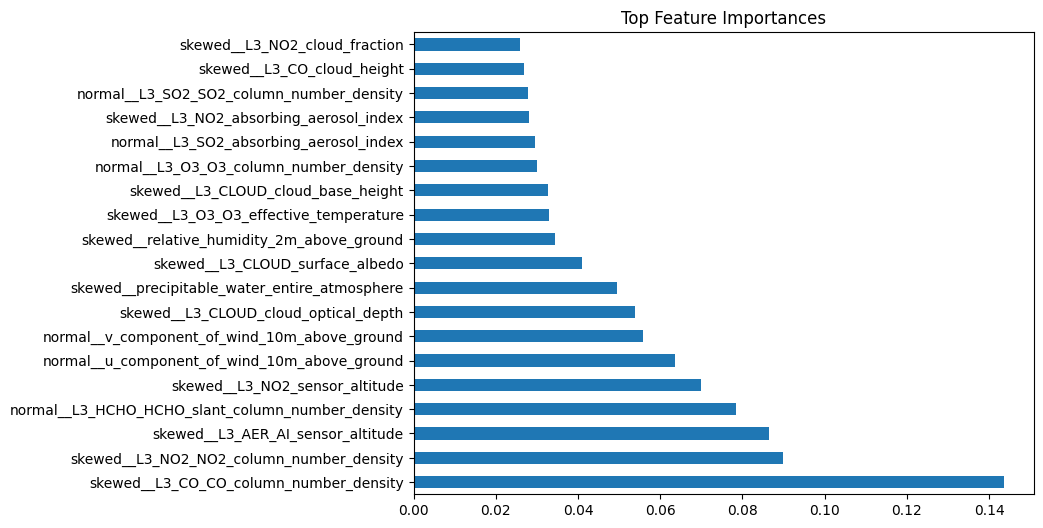

In [103]:
# plot feature importance (for tree models)
rf = model.named_steps['model']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

importances = pd.Series(rf.feature_importances_, index=feature_names)
importances.nlargest(30).plot(kind='barh', figsize=(8,6))
plt.title("Top Feature Importances")
plt.show()

# top 5 RF:
# skewed__L3_CO_CO_column_number_density              0.143631
# skewed__L3_NO2_NO2_column_number_density            0.089796
# skewed__L3_AER_AI_sensor_altitude                   0.086519
# normal__L3_HCHO_HCHO_slant_column_number_density    0.078402
# skewed__L3_NO2_sensor_altitude                      0.069834

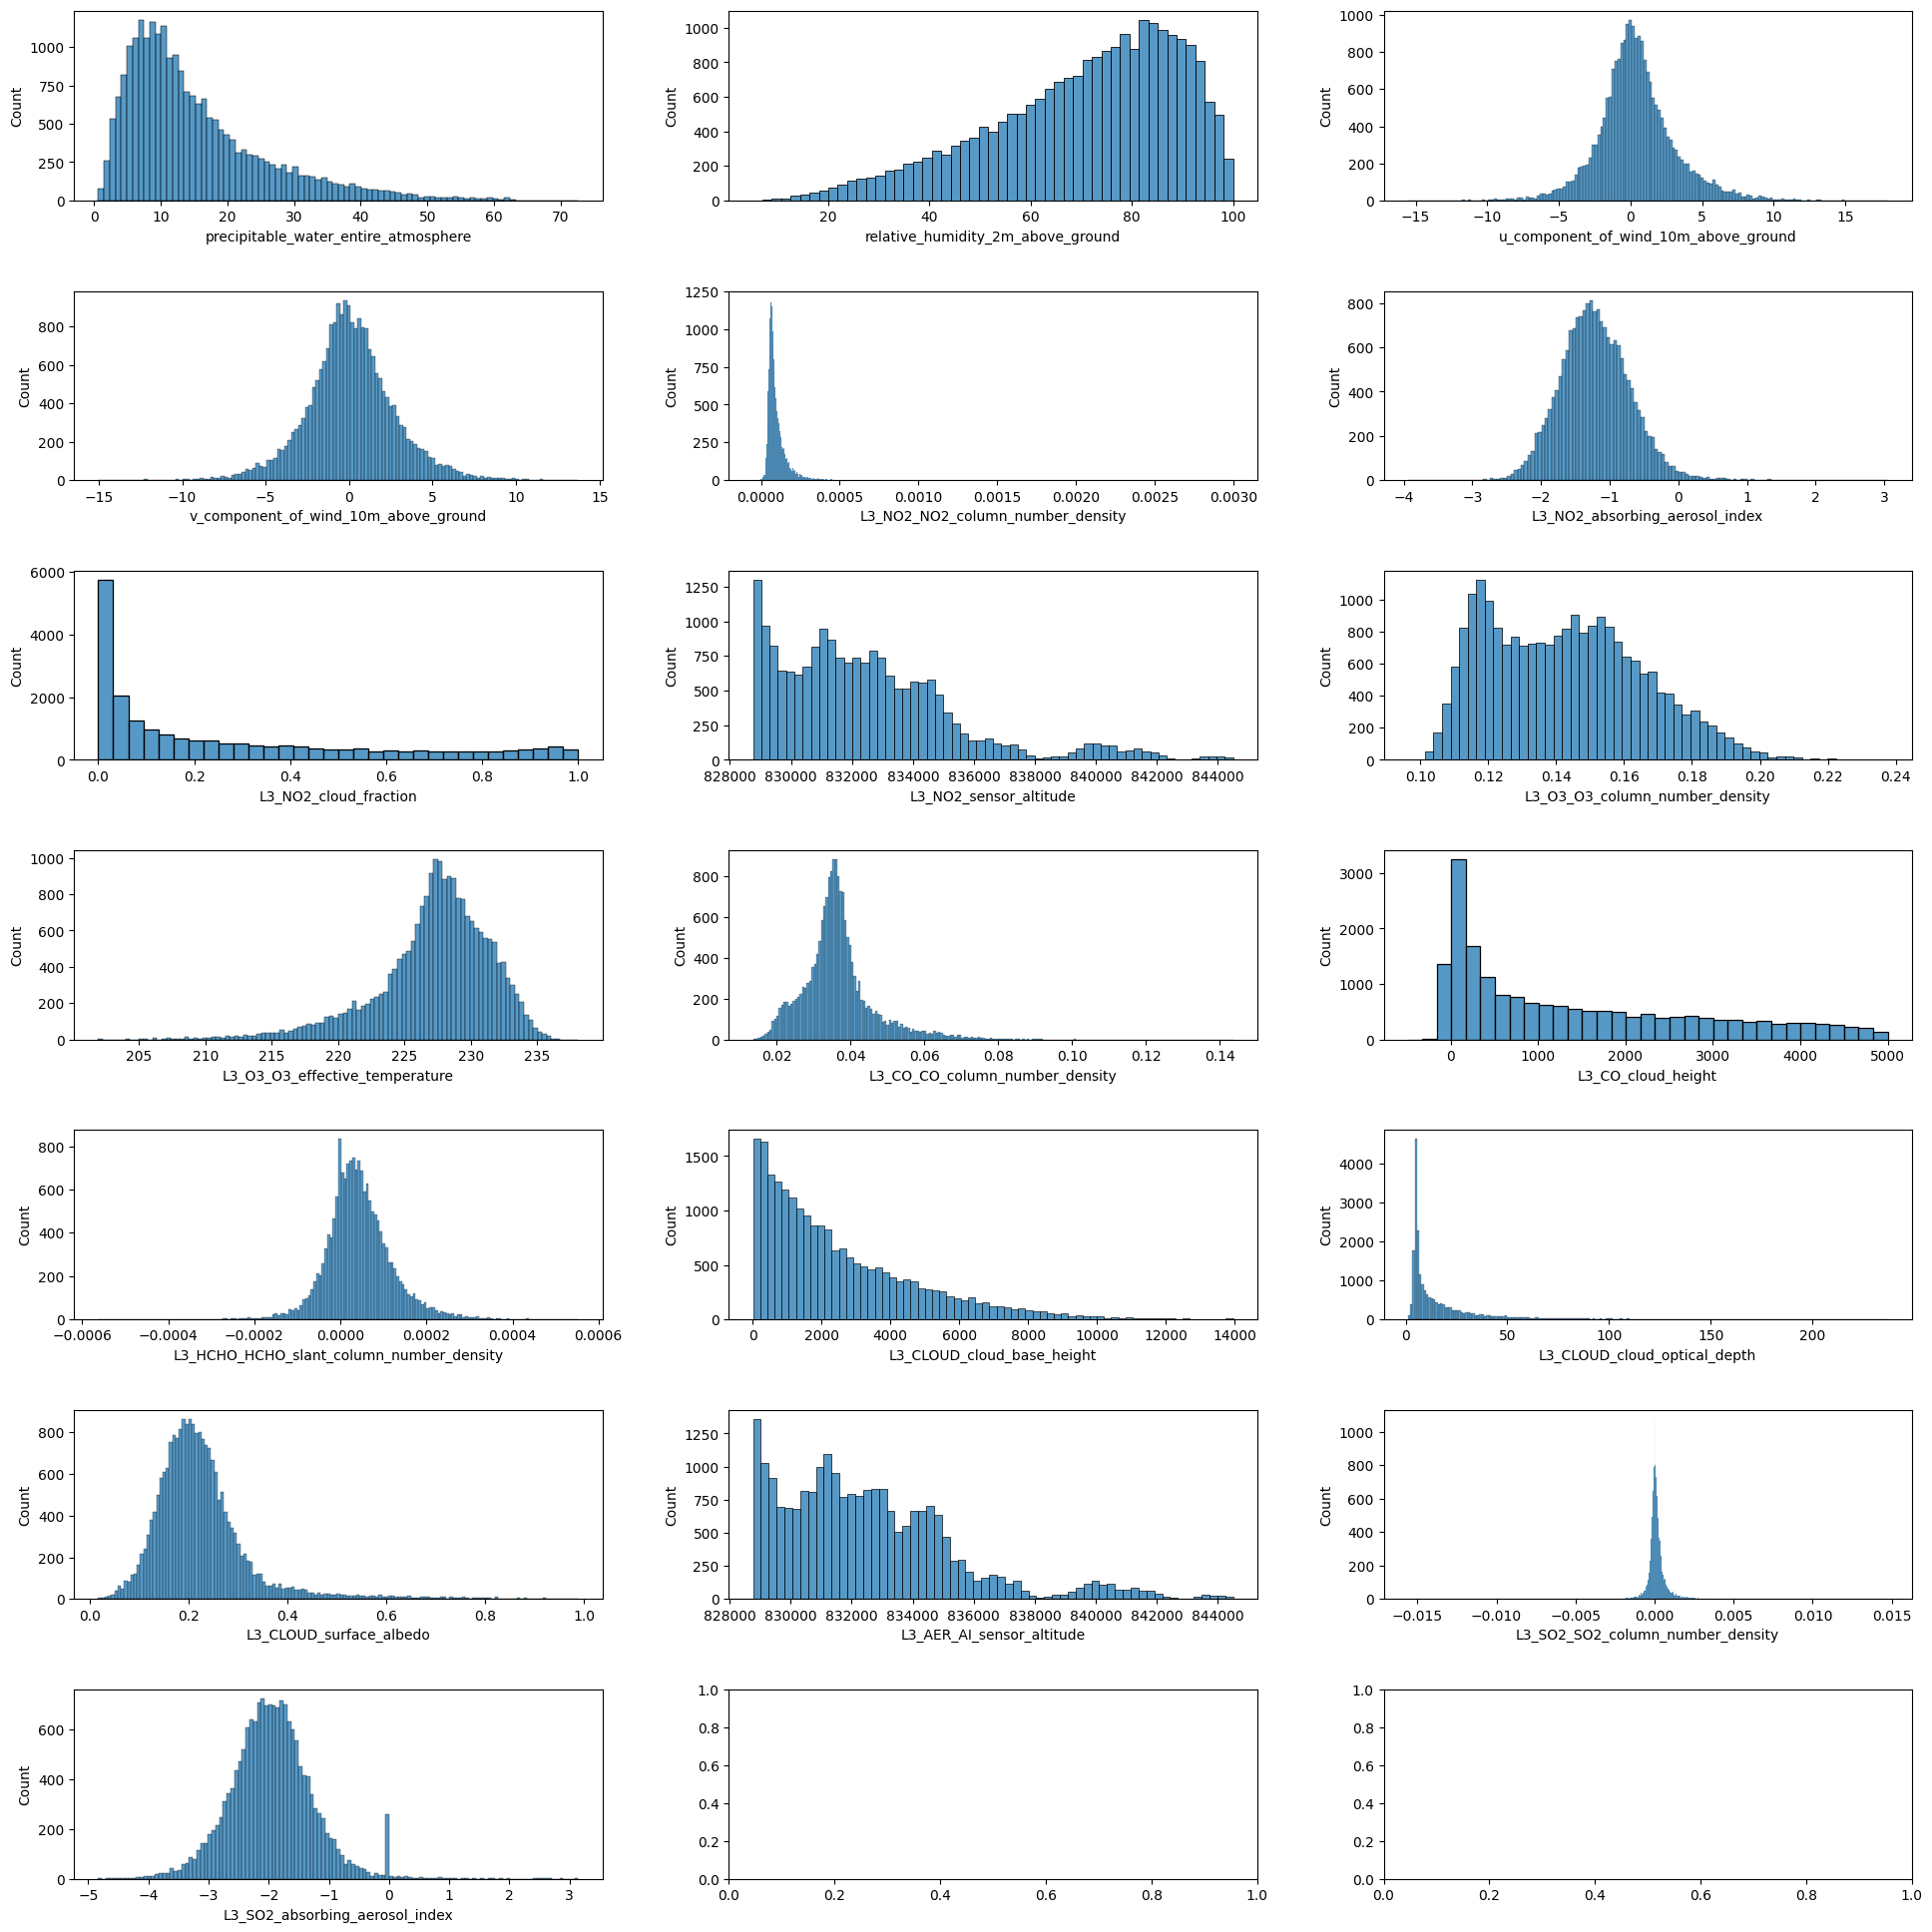

In [90]:
# visualize post-pipe

fix, axes = plt.subplots(7, 3, figsize=(20, 20))
axes = axes.flatten()

for ax, col in zip(axes, X_train.columns[:]):
    sns.histplot(X_train, x=col, ax=ax)

plt.tight_layout(pad=3)